In [334]:
import os, sys
from os.path import join

import nibabel as nib
import numpy as np
import pandas as pd

from nilearn.image import index_img
from nilearn.image import load_img
from nilearn.image import mean_img
from nilearn.image import new_img_like
from nilearn.masking import apply_mask

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'show', 'clf', 'plotting']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Multivoxel approaches
This notebook explores whether we can build a multivoxel model for predicting the trial state (REST, MOTOR, IMAGERY) based on the first run of data, and then apply that model to subsequent runs. 


# Prep Inputs

In [335]:
# load timing files
trialOnsets = pd.read_csv('../data/subject001/timingFiles/trialOnsets.tsv', sep='\t')
trialOnsets

,onsets_TR1,onsets_TR2,trialTypes,weights,duration
0,4,2,rest,1.0,20
1,24,22,motor,1.0,10
2,34,32,rest,1.0,20
3,54,52,imagery,1.0,10
4,64,62,rest,1.0,20
5,84,82,imagery,1.0,10
6,94,92,rest,1.0,20
7,114,112,motor,1.0,10
8,124,122,rest,1.0,20
9,144,142,imagery,1.0,10


In [336]:
# task labels
labels_1s = np.array(['nan'] * 186, dtype=object)
labels_1s_exclude2 = np.array(['nan'] * 186, dtype=object)
labels_2s = np.array(['nan'] * 93, dtype=object)

#loop over trialOnsets to populate labels arrays
for i,row in trialOnsets.iterrows():
    # 1s TRs
    startIdx = row['onsets_TR1']
    endIdx = startIdx + row['duration']+1
    labels_1s[startIdx:endIdx] = row['trialTypes']
    
    # 1s TRs, exclude 2s
    startIdx = row['onsets_TR1'] + 2
    endIdx = startIdx + row['duration'] - 2
    labels_1s_exclude2[startIdx:endIdx] = row['trialTypes']
    
    # 2s TRs
    startIdx = row['onsets_TR2']/2
    endIdx = startIdx + row['duration']/2 + 1
    labels_2s[int(startIdx):int(endIdx)] = row['trialTypes']
    
# convert to pandas series
labels_1s = pd.Series(labels_1s)
labels_1s_exclude2 = pd.Series(labels_1s_exclude2)
labels_2s = pd.Series(labels_2s)

We now have two arrays representing timept labels for each TR type (i.e. 1s vs 2s):
* **labels_1s**: timept labels for each volume in the 1s TR runs
* **labels_1s_exclude2**: timept labels for each volume, excluding 2s of "transition" around each trial switch
* **labels_2s**: timept labels for each volume in the 2s TR runs

# First run model, Motor vs Rest

Try to train a classifier to accurately predict REST from MOTOR timepts based on the first run ONLY

**Goal:** Find the mask and model parameters that yield the maximum classification accuracy between MOTOR and REST timepts

Using an SVM binary classifier, we'll train/test the model using Kfold cross validation with features obtained from the following masks:
* functionally defined (5mm sphere around peak for MOTOR>REST contrast)
* anatomically defined (full L primary motor cortex)
* anatomically defined (L primary motor cortext thresholded at >50% prob)
* whole brain

For each mask, we'll compute classification accuracy for:
* all MOTOR and REST volumes
* exclude 2s of "transition" volumes between each trial

In [337]:
# import necessary libraries
from nilearn.input_data import NiftiMasker
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

from nilearn import plotting
from nilearn.plotting import plot_stat_map, show

In [338]:
# build a function to compute mean cross validation score for a given mask and condition label vector
def runClassification(mask, labels):
    """
    inputs:
        - mask: path to the mask file 
        - labels: a 1xNumTimepts array of timept labels 
    """
    
    # set up masker based on the mask
    masker = NiftiMasker(mask_img=mask, standardize=True)
    
    # load fMRI corresponding to voxels within mask
    fmri = masker.fit_transform('../data/subject001/pyneal_002/receivedFunc.nii.gz')
    
    # create an array mask for the conditions of interest
    conditions_mask = labels.isin(['rest', 'motor'])
    
    # grab only the fMRI data timepts that we're interested in
    fmri = fmri[conditions_mask]
    
    # mask the labels vector to match
    labels = labels[conditions_mask]
    
    # build the SVM decoder
    svc = SVC(kernel='linear', C=100)
    
    # set up cross-validator
    cv = KFold(n=len(fmri), n_folds=5)
    
    # run cross-validation
    cv_score = cross_val_score(svc, fmri, labels, cv=cv)
    
    return cv_score
    
    print('{} - mean accuracy: {}, stdDev: {}'.format(os.path.split(mask)[-1], np.mean(cv_score), np.std(cv_score)))

In [339]:
masks = ['motorSphere_5mm_FUNC_mask.nii.gz',
         'motorCortex_FUNC_mask.nii.gz',
         'motorCortex_50prob_FUNC_mask.nii.gz',
         'wholeBrain_FUNC_mask.nii.gz']

allResults = pd.DataFrame(columns=['mask', 'labels', 'meanAcc', 'stdDev'])

for mask in masks:
    for labels in ['all', 'exclude2']:
        # full path to mask file
        maskFile = join('../data/subject001/pyneal_002/mask_transforms/FUNC_masks', mask)
        
        # set the correct labels var
        if labels == 'all':
            theseLabels = labels_1s
        elif labels == 'exclude2':
            theseLabels = labels_1s_exclude2
            
        cv_scores = runClassification(maskFile, theseLabels)
        
        # add results to dataframe
        allResults = allResults.append({'mask': mask, 
                                     'labels': labels, 
                                     'meanAcc': np.mean(cv_scores), 
                                     'stdDev': np.std(cv_scores)}, ignore_index=True)
                         
allResults
        

,mask,labels,meanAcc,stdDev
0,motorSphere_5mm_FUNC_mask.nii.gz,all,0.861720,0.082855
1,motorSphere_5mm_FUNC_mask.nii.gz,exclude2,0.962393,0.033777
2,motorCortex_FUNC_mask.nii.gz,all,0.888602,0.098900
3,motorCortex_FUNC_mask.nii.gz,exclude2,0.925071,0.077562
4,motorCortex_50prob_FUNC_mask.nii.gz,all,0.835269,0.075638
5,motorCortex_50prob_FUNC_mask.nii.gz,exclude2,0.894302,0.072054
6,wholeBrain_FUNC_mask.nii.gz,all,0.875484,0.114390
7,wholeBrain_FUNC_mask.nii.gz,exclude2,0.909687,0.076423


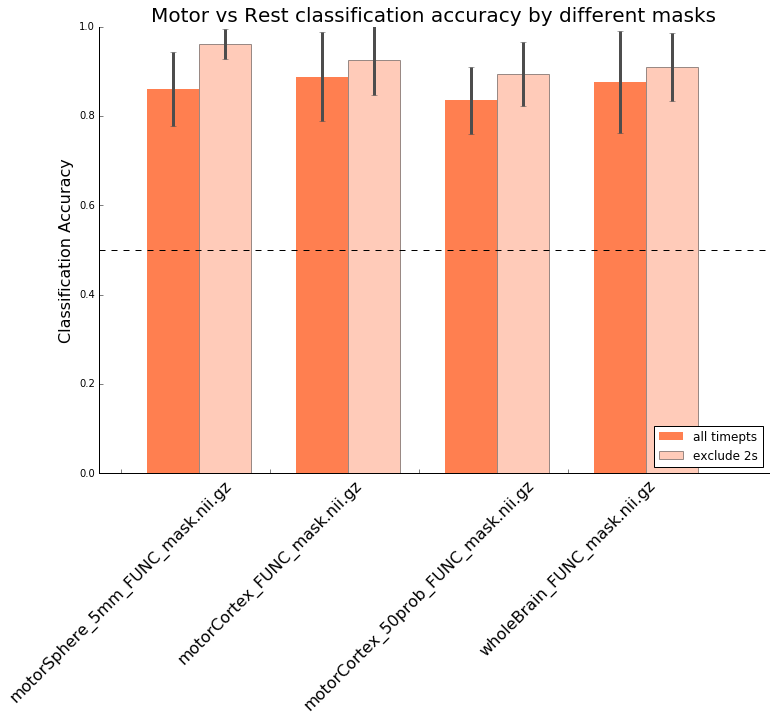

In [205]:
xInd = np.arange(4)
width = 0.35

fig,ax = plt.subplots(figsize=(12,8))
error_config = {'ecolor': '0.3', 'lw':3}

# all timepoints plot
allTmpts = allResults.loc[allResults['labels'] == 'all']
rects1 = ax.bar(xInd-width/2, 
                allTmpts['meanAcc'], 
                width, 
                yerr=allTmpts['stdDev'],
                error_kw=error_config,
                color='coral',
                edgecolor='none',
                label='all timepts')


# exclude 2s plot
exclude2 = allResults.loc[allResults['labels'] == 'exclude2']
rects2 = ax.bar(xInd+width/2,
               exclude2['meanAcc'],
               width,
               yerr=exclude2['stdDev'],
               error_kw=error_config,
               color='coral',
               alpha=.4,
               edgecolor='none',
               label='exclude 2s')

ax.axhline(y=.5, color='k', ls='--')

# format plot
ax.set_ylabel('Classification Accuracy', fontsize=16)
ax.set_ylim([0,1])
ax.set_title('Motor vs Rest classification accuracy by different masks', fontsize=20)
ax.set_xticks(xInd-width)
ax.set_xticklabels(masks, rotation=45, fontsize=16)
ax.legend(loc=4)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(top='off', right='off')

# Test model on subsequent runs

The best model was the one using the **motorSphere_5mm_FUNC_mask.nii.gz** mask and the **exclude 2s** labels. Take this model, and test it on other runs

In [234]:
mask = 'motorSphere_5mm_FUNC_mask.nii.gz'

# check how many voxels are in the masks for each run (given that there was different coverage areas afterall)
for run in ['002', '003', '004', '005']:
    mask_img = load_img(join('../data/subject001/pyneal_{}/mask_transforms/FUNC_masks'.format(run), mask))

    print('run_{} - {} voxels'.format(run, int(sum(mask_img.get_data()))))

run_002 - 63 voxels
run_003 - 68 voxels
run_004 - 63 voxels
run_005 - 58 voxels


In [274]:
maskPath =  join('../data/subject001/pyneal_002/mask_transforms/FUNC_masks', mask)
labels = labels_1s_exclude2

## recreate the model
# set up masker based on the mask
masker = NiftiMasker(mask_img=maskPath, standardize=True)

# load fMRI corresponding to voxels within mask
run1 = masker.fit_transform('../data/subject001/pyneal_002/receivedFunc.nii.gz')

# since the 4th run only has 58 voxels in the mask, truncate this data to the first 58 voxels only
run1 = run1[:, :58]

# create an array mask for the conditions of interest
conditions_mask = labels.isin(['rest', 'motor'])

# grab only the fMRI data timepts that we're interested in
run1_masked = run1[conditions_mask]

# mask the labels vector to match
labels = labels[conditions_mask]

# build the SVM classifier
clf = SVC(kernel='linear', C=100, probability=True)
clf.fit(run1_masked, labels)

# just for fun, run cross-validation using this smaller masked dataset just to make sure accuracy is still good
#clf = SVC(kernel='linear', C=100, probability=True)
cv = KFold(n=len(run1_masked), n_folds=5)
cv_score = cross_val_score(clf, run1_masked, labels, cv=cv)
print(cv_score)

[ 0.92592593  1.          1.          0.92307692  0.96153846]


## Write a function to run each timept through the classifier

In [295]:
def classifyRun(run, mask, clf):
    
    # path to the mask
    maskPath =  '../data/subject001/{}/mask_transforms/FUNC_masks/{}'.format(run, mask)
    masker = NiftiMasker(mask_img=maskPath, standardize=True)
    
    # load the run data
    fmri = masker.fit_transform('../data/subject001/{}/receivedFunc.nii.gz'.format(run))
    
    # truncate to the first 58 voxels only
    fmri = fmri[:, :58]
    
    # empty vars to store class prediction and probability
    predicted_class = []
    predicted_prob = []
    
    # loop over each timept
    for sampleIdx in range(fmri.shape[0]):
        # grab this sample
        sample = fmri[sampleIdx, :].reshape(1,fmri.shape[1])  # reshape to (1,nFeatures)

        # predict class
        predicted_class.append(clf.predict(sample)[0])
        
        # report the probability it's a motor trial
        motorIdx = np.where(clf.classes_ == 'motor')[0][0]   # get the index of where the motor prob will be
        motorProb = clf.predict_proba(sample)[motorIdx][0]
        predicted_prob.append(motorProb)
        
    return np.array(predicted_class), np.array(predicted_prob)
    
        

In [296]:
run = 'pyneal_003'

predictedClasses, predictedProb = classifyRun(run, mask, clf)

## plot output of classifier for each run

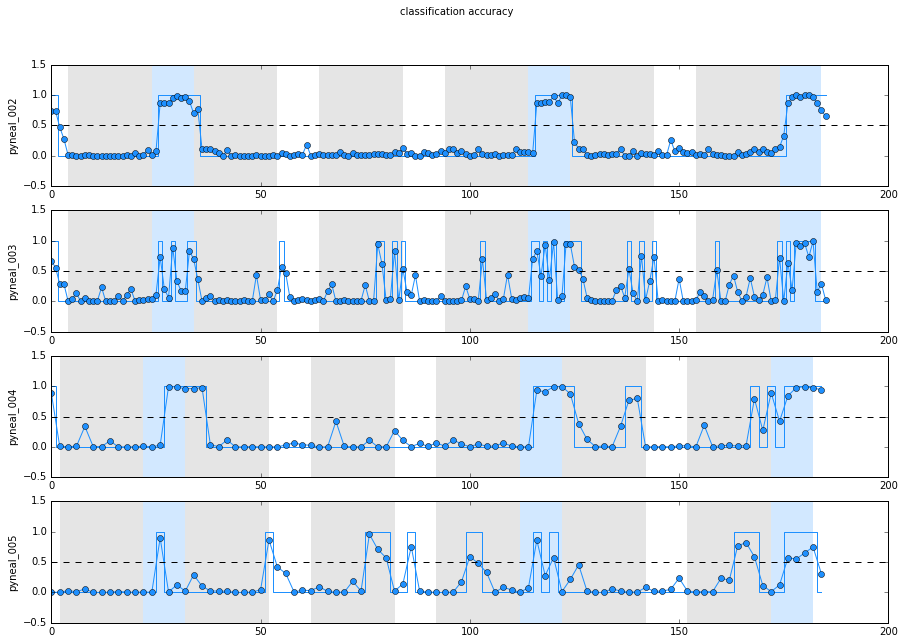

In [311]:
trialType = 'motor'

fig, axs = plt.subplots(4,1, figsize=(15,10))
plt.suptitle('classification accuracy')

for i,run in enumerate(['pyneal_002', 'pyneal_003', 'pyneal_004', 'pyneal_005']):
    
    # get the predicted classes and prediction probabilities for this run
    classes, probs = classifyRun(run, mask, clf)
    
    # plot
    if run in ['pyneal_002', 'pyneal_003']:
        # use 1s TR
        x = np.arange(0,186,1)
        
        # get onsets for trials
        restOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'rest', ['onsets_TR1','duration']]
        restOnsets.rename(index=str, columns={"onsets_TR1":"onsets"}, inplace=True)
        taskOnsets = trialOnsets.loc[trialOnsets.trialTypes == trialType, ['onsets_TR1', 'duration']]
        taskOnsets.rename(index=str, columns={"onsets_TR1":"onsets"}, inplace=True)
        
    else:
        # use 2s TR
        x = np.arange(0,186,2)

        # get onsets for trials
        restOnsets = trialOnsets.loc[trialOnsets.trialTypes == 'rest', ['onsets_TR2','duration']]
        restOnsets.rename(index=str, columns={"onsets_TR2":"onsets"}, inplace=True)
        taskOnsets = trialOnsets.loc[trialOnsets.trialTypes == trialType, ['onsets_TR2', 'duration']]
        taskOnsets.rename(index=str, columns={"onsets_TR2":"onsets"}, inplace=True)
        
    axs[i].set(ylabel=run)
    
    # set span color
    if trialType == 'motor':
        spanColor = 'dodgerblue'
        lineColor = 'dodgerblue'
    elif trialType == 'imagery':
        spanColor = 'goldenrod'
        lineColor = 'goldenrod'
    
    # draw the spans
    for r,row in restOnsets.iterrows():
        onset = row['onsets']
        axs[i].axvspan(onset, onset+row['duration'], facecolor='gray', edgecolor='none', alpha=0.2)

    for r,row in taskOnsets.iterrows():
        onset = row['onsets']
        axs[i].axvspan(onset, onset+row['duration'], facecolor=spanColor, edgecolor='none', alpha=0.2)
        
    # draw the predicted class
    axs[i].step(x, y=np.array(classes == 'motor', dtype=int), where='mid', color='dodgerblue')
    
    # draw the prediction probability
    axs[i].plot(x, np.array(probs), '-o', color='dodgerblue')
    
    # format plot
    axs[i].axhline(y=.5, color='k', ls='--')
    axs[i].set_ylim(-.5, 1.5)
    
    

# test how to save and reload classifier
try to save the classifier as a pickle object, and then reload and test it

In [313]:
import pickle

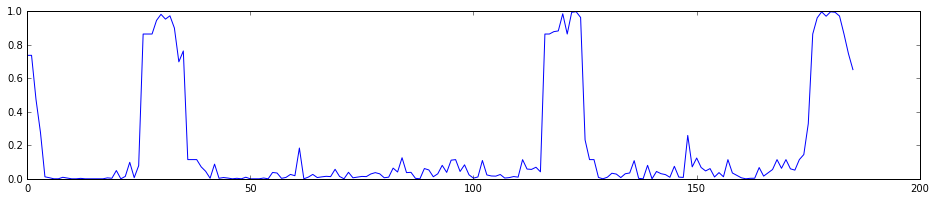

In [325]:
# comparison data for after saving and reloading the classifier 
classes, probs = classifyRun('pyneal_002', mask, clf)

plt.figure(figsize=(16,3))
plt.plot(probs)

In [333]:
# save the classifier
with open('testClassifier.pkl', 'wb') as p:
    pickle.dump(clf, p, pickle.HIGHEST_PROTOCOL)

In [329]:
!ls

subject001_ROIanalyses.ipynb subject001_multivoxel.ipynb
subject001_multivoxel.html   testClassifier.pkl


In [414]:
with open('testClassifier.pkl', 'rb') as p:
    newClf = pickle.load(p)

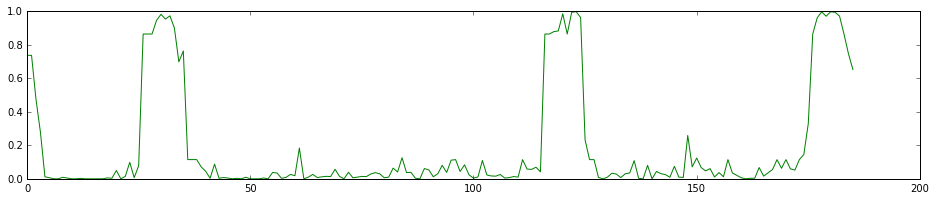

In [332]:
newClasses, newProbs = classifyRun('pyneal_002', mask, newClf)

plt.figure(figsize=(16,3))
plt.plot(probs, 'g-')

Good, confirms saving and loading a trained classifier will work. Now build a fresh classifier based entirely off run 1 and save it to a sensible place

In [485]:
### Train a classifier on the entirity of run 1
maskFile = 'motorSphere_5mm_FUNC_mask.nii.gz'
maskPath =  join('../data/subject001/pyneal_002/mask_transforms/FUNC_masks', maskFile)
labels = labels_1s_exclude2

## recreate the model
# set up masker based on the mask
masker = NiftiMasker(mask_img=maskPath, standardize=True)

# load fMRI corresponding to voxels within mask
run1 = masker.fit_transform('../data/subject001/pyneal_002/receivedFunc.nii.gz')

# create an array mask for the conditions of interest
conditions_mask = labels.isin(['rest', 'motor'])

# grab only the fMRI data timepts that we're interested in
run1_masked = run1[conditions_mask]

# mask the labels vector to match
labels = labels[conditions_mask]

# build the SVM classifier
run1_clf = SVC(kernel='linear', C=100, probability=True)
run1_clf.fit(run1_masked, labels)

# save the classifier
with open('../pynealAnalysis/pyneal_002_motor-vs-rest_classifier.pkl', 'wb') as p:
    pickle.dump(run1_clf, p, pickle.HIGHEST_PROTOCOL)


# build a classifier tool that does not rely on nilearn for masking the data
This is to ensure that we can apply the mask in the SAME way, and thus extract the SAME voxels for both training the classifier and then applying it to subsequent runs

In [438]:
def classifyRun_noNilearn(run, mask, clf):
    
    # path to the mask
    maskPath =  '../data/subject001/{}/mask_transforms/FUNC_masks/{}'.format(run, mask)
    
    # load mask
    mask = nib.load(maskPath).get_data().astype('bool')
    
    # load fmri data
    fmri = nib.load('../data/subject001/{}/receivedFunc.nii.gz'.format(run)).get_data()
    
    # mask fmri data to get nSamples x nVoxels array
    masked_fmri = np.zeros(shape=(fmri.shape[3], sum(mask.ravel())))
    for t in range(fmri.shape[3]):
        thisVol = fmri[:,:,:,t]
        maskedVol = thisVol[mask]
        
        masked_fmri[t,:] = maskedVol
    
    # NILEARN WAY OF DOING IT --------
    #masker = NiftiMasker(mask_img=maskPath, standardize=True)
    
    # load the run data
    #fmri = masker.fit_transform('../data/subject001/{}/receivedFunc.nii.gz'.format(run))
    # ---------------------------------
    
    # truncate to the first 58 voxels only
    fmri = masked_fmri[:, :58]
    
    ### detrend everything BEFORE iterating through the timeseries
    fmri = fmri - fmri.mean(axis=0)   # remove mean
    std = np.sqrt((fmri**2).sum(axis=0))  # calculate standard deviation
    std[std < np.finfo(np.float).eps] = 1.  # avoids numerical problems
    fmri /= std    # divide every value in fmri by the std
    fmri *= np.sqrt(fmri.shape[0])  # unit variance (i.e. 1) by multiplying by the square root of the number of samples
    clean_fmri = meanCenter_fmri
    
    # empty vars to store class prediction and probability
    predicted_class = []
    predicted_prob = []
    
    # loop over each timept
    for sampleIdx in range(fmri.shape[0]):
        # grab this sample
        sample = fmri[sampleIdx, :].reshape(1,fmri.shape[1])  # reshape to (1,nFeatures)

        # predict class
        predicted_class.append(clf.predict(sample)[0])
        
        # report the probability it's a motor trial
        motorIdx = np.where(clf.classes_ == 'motor')[0][0]   # get the index of where the motor prob will be
        motorProb = clf.predict_proba(sample)[motorIdx][0]
        predicted_prob.append(motorProb)
        
    return np.array(predicted_class), np.array(predicted_prob)
    

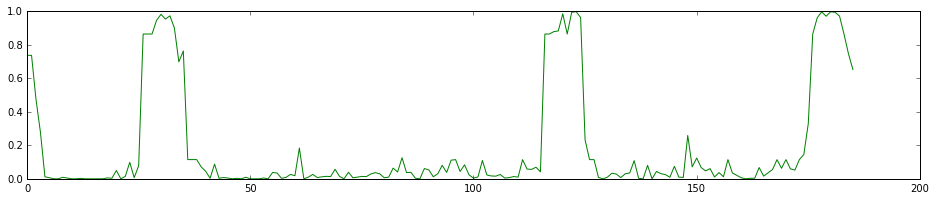

In [439]:
run = 'pyneal_002'
maskFile = 'motorSphere_5mm_FUNC_mask.nii.gz'

predictedClasses, predictedProb = classifyRun_noNilearn(run, maskFile, newClf)

plt.figure(figsize=(16,3))
plt.plot(predictedProb, 'g-')

This is great cause it confirms that we can mask fmri data, convert to a 2D array (nSamples x nVoxels), standardize, and classify each sample in a way the recreates the nilearn approach, but without having to rely on their tools (which requires data formatted in a specific way that we don't want to have to do during a real-time run)

Next, need to see how classification accuracy degrades if you standardized in an iteratively way on each volume. That is, instead of standardizing all of the data at once BEFORE beginning, we need to standardize each volume based on only the volumes that PRECEDE it in time. This is what we'll have to do during a real-time run, since we won't have the benefit of having all data ahead of time

# standardize iteratively and classifiy

In [460]:
def classifyRun_iterStd(run, mask, clf):
    
    # path to the mask
    maskPath =  '../data/subject001/{}/mask_transforms/FUNC_masks/{}'.format(run, mask)
    
    # load mask
    mask = nib.load(maskPath).get_data().astype('bool')
    
    # load fmri data
    fmri = nib.load('../data/subject001/{}/receivedFunc.nii.gz'.format(run)).get_data()
    
    # mask fmri data to get nSamples x nVoxels array
    masked_fmri = np.zeros(shape=(fmri.shape[3], sum(mask.ravel())))
    for t in range(fmri.shape[3]):
        thisVol = fmri[:,:,:,t]
        maskedVol = thisVol[mask]
        
        masked_fmri[t,:] = maskedVol
    
    # NILEARN WAY OF DOING IT --------
    #masker = NiftiMasker(mask_img=maskPath, standardize=True)
    
    # load the run data
    #fmri = masker.fit_transform('../data/subject001/{}/receivedFunc.nii.gz'.format(run))
    # ---------------------------------
    
    # truncate to the first 58 voxels only
    fmri = masked_fmri[:, :58]
    
    ### detrend everything BEFORE iterating through the timeseries
#     fmri = fmri - fmri.mean(axis=0)   # remove mean
#     std = np.sqrt((fmri**2).sum(axis=0))  # calculate standard deviation
#     std[std < np.finfo(np.float).eps] = 1.  # avoids numerical problems
#     fmri /= std    # divide every value in fmri by the std
#     fmri *= np.sqrt(fmri.shape[0])  # unit variance (i.e. 1) by multiplying by the square root of the number of samples
#     clean_fmri = meanCenter_fmri
    
    # empty vars to store class prediction and probability
    predicted_class = []
    predicted_prob = []
    
    # loop over each timept
    for sampleIdx in range(fmri.shape[0]):
        
        # standardize voxel timeseries on all datapoints up to the current one
        
        theseSamples = fmri[:sampleIdx+1, :]
        std_fmri = standardize(theseSamples)
        
        # grab this sample
        sample = std_fmri[sampleIdx, :].reshape(1,fmri.shape[1])  # reshape to (1,nFeatures)

        # predict class
        predicted_class.append(clf.predict(sample)[0])
        
        # report the probability it's a motor trial
        motorIdx = np.where(clf.classes_ == 'motor')[0][0]   # get the index of where the motor prob will be
        motorProb = clf.predict_proba(sample)[motorIdx][0]
        predicted_prob.append(motorProb)
        
    return np.array(predicted_class), np.array(predicted_prob)


def standardize(signals):
    """
    signals expected to be a 2D array of timeseries with
    time on the first axis (rows) and features on the second
    axis (colums). This method will mean center each feature, and
    set the variance to 1.
    
    returns standardized signals array
    """
-

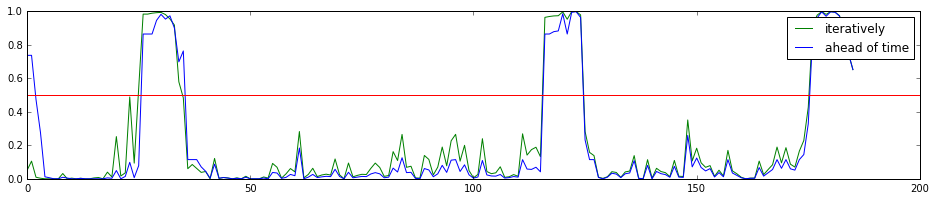

In [483]:
run = 'pyneal_002'
maskFile = 'motorSphere_5mm_FUNC_mask.nii.gz'

predictedClasses_iterStd, predictedProb_iterStd = classifyRun_iterStd(run, maskFile, newClf)
predictedClasses, predictedProb = classifyRun_noNilearn(run, maskFile, newClf)

plt.figure(figsize=(16,3))
plt.plot(predictedProb_iterStd, 'g-', label='iteratively')
plt.plot(predictedProb, 'b-', label='ahead of time')
plt.axhline(y=.5, color='r')
plt.legend()

Excellent, this confirms that standardizing the data iteratively on each new volume doesn't substantially change the classification outcomes

In [423]:
### confirm that standardization works:

run = 'pyneal_002'
maskFile = 'motorSphere_5mm_FUNC_mask.nii.gz'

# path to the mask
maskPath =  '../data/subject001/{}/mask_transforms/FUNC_masks/{}'.format(run, maskFile)

# load mask
mask = nib.load(maskPath).get_data().astype('bool')

# load fmri data
fmri = nib.load('../data/subject001/{}/receivedFunc.nii.gz'.format(run)).get_data()

# mask fmri data to get nSamples x nVoxels array
masked_fmri = np.zeros(shape=(fmri.shape[3], sum(mask.ravel())))
for t in range(fmri.shape[3]):
    thisVol = fmri[:,:,:,t]
    maskedVol = thisVol[mask]

    masked_fmri[t,:] = maskedVol

In [424]:
masked_fmri.shape

(186, 63)

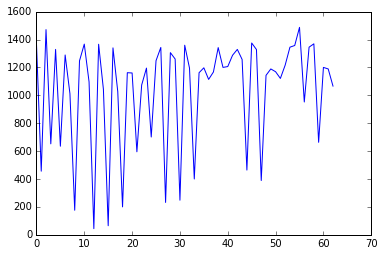

In [425]:
# pre standardization
plt.plot(masked_fmri[100, :])

In [430]:
# standardize
meanCenter_fmri = masked_fmri - masked_fmri.mean(axis=0)
std = np.sqrt((meanCenter_fmri**2).sum(axis=0))
std[std < np.finfo(np.float).eps] = 1.
meanCenter_fmri /= std
meanCenter_fmri *= np.sqrt(meanCenter_fmri.shape[0])
clean_fmri = meanCenter_fmri

In [432]:
clean_fmri.shape

(186, 63)

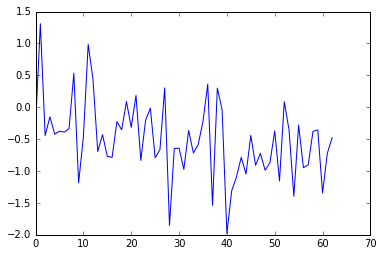

In [433]:
plt.plot(clean_fmri[100, :])

# misc

In [352]:
mask = 'motorSphere_5mm_FUNC_mask.nii.gz'

In [382]:
mask_img = nib.load(join('../data/subject001/pyneal_002/mask_transforms/FUNC_masks', mask))

In [467]:
newClf

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [478]:
a = fmri[:,:,:,100]
masked_a = a[mask].reshape(1, 63)
masked_a = masked_a[:,:58]
c = newClf.predict(masked_a)[0]

In [481]:
newClf.classes_

array(['motor', 'rest'], dtype=object)

In [454]:
a = np.ones(shape=(3,10))

In [455]:
a[:1, :]

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [436]:
a += 2

In [440]:
a = np.array([1])

In [356]:
maskFlat.shape

(96000,)

In [367]:
fmri = nib.load('../data/subject001/pyneal_002/receivedFunc.nii.gz')

In [368]:
fmri.shape

(80, 80, 15, 186)

In [371]:
thisVol = fmri.get_data()[:,:,:,100]

In [388]:
mask = mask_img.get_data().astype('bool')

In [401]:
# mask the voxel
maskedVol = thisVol[mask]

In [402]:
maskedVol.shape

(63,)

In [403]:
mask.shape

(80, 80, 15)

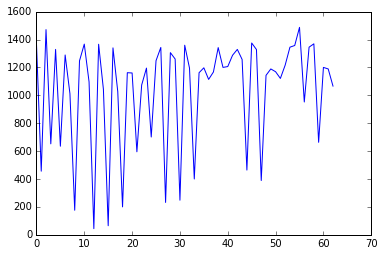

In [404]:
plt.plot(maskedVol[:,])

In [391]:
maskPath

'../data/subject001/pyneal_002/mask_transforms/FUNC_masks/motorSphere_5mm_FUNC_mask.nii.gz'

In [392]:
masker = NiftiMasker(mask_img=maskPath, standardize=True)

In [393]:
maskedVol = masker.fit_transform(fmri)


In [394]:
maskedVol.shape

(186, 63)

In [397]:
type(fmri)

nibabel.nifti1.Nifti1Image

In [405]:
maskedVol = masker.fit_transform(fmri)

In [406]:
maskedVol.shape

(186, 63)

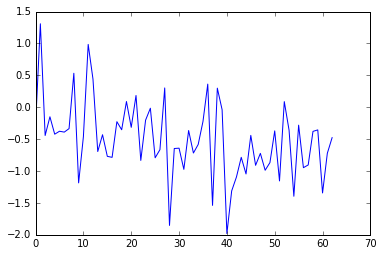

In [407]:
plt.plot(maskedVol[100, :])